In [151]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Functions

In [152]:
import seaborn as sns
import umap
from sklearn.decomposition import PCA

def generate_pca_embedding(matrix, n_components=2):
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'PCA{i+1}' for i in range(n_components)])
    return embedding

def generate_umap_embedding(matrix, n_components=2):

    reducer = umap.UMAP(n_components=n_components)
    embedding = reducer.fit_transform(matrix.T)
    if isinstance(matrix, pd.DataFrame):
        embedding = pd.DataFrame(embedding, index=matrix.columns, columns=[f'UMAP{i+1}' for i in range(n_components)])
    return embedding

def plot_pca(embedding,metadata,col_name,yes_umap=False):

    if yes_umap:
        xvar = 'UMAP1'
        yvar = 'UMAP2'
    else:
        xvar = 'PCA1'
        yvar = 'PCA2'
    if metadata[col_name].nunique() < 10:
        palette = sns.color_palette("tab10", metadata[col_name].nunique())
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name], palette=palette)
    else:
        sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=metadata[col_name])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name)
    plt.xlabel(xvar)
    plt.ylabel(yvar)

    # add counts to the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if metadata[col_name].nunique() < 15:
        labels = [f'{x} ({metadata[metadata[col_name]==x].shape[0]})' for x in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=col_name,
            ncol=2)  # ncol=2 makes the legend have 2 columns

    # add the number of samples to the title
    plt.title(f'N samples = {metadata[~metadata[col_name].isna()].shape[0]}')
    
def align_to_existing(input_intensity_matrix, pretrain_features, align_input, 
                      fill_na=False, std_scale=False, log2_scale=False,verbose=1,
                      full_missing_method='mean',partial_missing_method='mean',
                      fill_partial_missing_first=True):
    """
    Aligns input intensity matrix with pretrain features based on align input.

    Parameters:
    - input_intensity_matrix (pd.DataFrame): The input intensity matrix to align. Columns are features and rows are samples.
    - pretrain_features (list or pd.Index): The list or pd.Index of features used for pretraining (correspond to reference study features)
    - align_input (pd.DataFrame or pd.Series): The align input to use for alignment. has index of features from the reference study, 
    and values of the features from the input_intensity_matrix to align.
    - fill_na (bool, optional): Whether to fill missing values. Defaults to False. Missing values within the input study, 
        are filled by taking the average feature value, while features not present in the input study are filled by taking the average sample value.
    - std_scale (bool, optional): Whether to standardize the intensity matrix. Defaults to False.
    - log2_scale (bool, optional): Whether to log2 transform the intensity matrix. Defaults to False.
    - verbose (int, optional): The verbosity level. Defaults to 1.
    - full_missing_method (str, optional): The method to fill full missing values. Defaults to 'mean'. Options are 'mean', 'median', 'zero'.
    - partial_missing_method (str, optional): The method to fill partial missing values. Defaults to 'mean'. Options are 'mean', 'median'.
    - fill_partial_missing_first (bool, optional): Whether to fill partial missing values first. Defaults to True.


    Returns:
    - intensity_df (pd.DataFrame): The aligned intensity matrix.
    - nan_df (pd.DataFrame): A boolean DataFrame indicating missing values in the aligned intensity matrix.
    """
    if not isinstance(input_intensity_matrix, pd.DataFrame):
        raise ValueError('input_intensity_matrix should be a pandas DataFrame')

    if 'FT' not in input_intensity_matrix.columns[0][:2]:
        input_intensity_matrix = input_intensity_matrix.T

    if isinstance(align_input,pd.DataFrame):
        align_input = align_input.iloc[:,0].copy()

    common_pretrained_features = list(set(pretrain_features).intersection(align_input.index))
    if verbose > 1: print('Common pretrained features:', common_pretrained_features)
    if verbose > 0: print('number of common pretrained features:', len(common_pretrained_features))
    missing_pretrained_features = list(set(pretrain_features).difference(align_input.index))
    if verbose > 1: print('Missing pretrained features:', missing_pretrained_features)
    if verbose > 0: print('number of missing pretrained features:', len(missing_pretrained_features))
    align_input = align_input[common_pretrained_features].copy()
    
    input_features_aligned = align_input.values.tolist()
    pretrain_features_aligned = align_input.index.tolist()
    if isinstance(pretrain_features, pd.Index):
        pretrain_features = pretrain_features.tolist()
    

    output_matrix = np.empty((input_intensity_matrix.shape[0], len(pretrain_features)), dtype=float)
    output_matrix = output_matrix * np.nan
    output_matrix[:, [pretrain_features.index(f) for f in pretrain_features_aligned]] = input_intensity_matrix[input_features_aligned].values

    intensity_df = pd.DataFrame(output_matrix, index=input_intensity_matrix.index, columns=pretrain_features)
    nan_df = intensity_df.isnull()

    if log2_scale:
        intensity_df = np.log2(intensity_df + 1)

    if std_scale:
        scaler = StandardScaler()
        intensity_df = pd.DataFrame(scaler.fit_transform(intensity_df), index=intensity_df.index, columns=intensity_df.columns)
        
    if fill_na:
        # Fill partial missing values with the mean of the feature
        feats = intensity_df.columns
        full_missing_feats = feats[intensity_df.isna().sum(axis=0) == intensity_df.shape[0]]
        partial_missing_feats = feats[intensity_df.isna().sum(axis=0) < intensity_df.shape[0]]
        
        partial_missing = intensity_df.loc[:,partial_missing_feats].copy()

        if fill_partial_missing_first:
            if verbose>0: print('Warning: inpute the NA of the partial missing values first, may impact how the full missing values are filled')
            if partial_missing_method == 'mean':
                partial_missing.fillna(partial_missing.mean(), inplace=True)
            elif partial_missing_method == 'median':
                partial_missing.fillna(partial_missing.median(), inplace=True)
            else:
                raise ValueError('partial_missing_method of {} is not yet supported'.format(partial_missing_method))

        if full_missing_method == 'mean':
            full_missing = intensity_df.loc[:,full_missing_feats].copy()
            full_missing = full_missing.T
            full_missing.fillna(partial_missing.mean(axis=1), inplace=True)
            full_missing = full_missing.T
        elif full_missing_method == 'median':
            full_missing = intensity_df.loc[:,full_missing_feats].copy()
            full_missing = full_missing.T
            full_missing.fillna(partial_missing.median(axis=1), inplace=True)
            full_missing = full_missing.T
        elif full_missing_method == 'zero':
            full_missing = intensity_df.loc[:,full_missing_feats].copy()
            full_missing.fillna(0, inplace=True)

        if not fill_partial_missing_first:
            # do this after so we don't the filling of the "full-missing" is not impacted by how we fill the partial missing
            if partial_missing_method == 'mean':
                partial_missing.fillna(partial_missing.mean(), inplace=True)
            elif partial_missing_method == 'median':
                partial_missing.fillna(partial_missing.median(), inplace=True)
            else:
                raise ValueError('partial_missing_method of {} is not yet supported'.format(partial_missing_method))

        intensity_df = pd.concat([partial_missing, full_missing], axis=1)
    

    return intensity_df, nan_df

## Set up the Pretraining info

### Get the list of features used for pretraining

In [153]:
#Load the pretrained features corresponding to the Ref Study (ST001237)
pretrain_feats_file = 'pretrain_feats.txt'
pretrain_feats = pd.read_csv(pretrain_feats_file, header=None)[0].tolist()

In [154]:
# x_rcc_test_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/April_30_Finetune_Data/X_finetune_test.csv'
# x_rcc_test = pd.read_csv(x_rcc_test_file, index_col=0)
# pretrain_feats = x_rcc_test.columns

# # save the pretrain features to a list
# pretrain_feats_file = 'pretrain_feats.txt'
# with open(pretrain_feats_file, 'w') as f:
#     for item in pretrain_feats:
#         f.write("%s\n" % item)

In [155]:
# The base directory for saving stuff
SAVE_BASE_DIR = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/July_09_Data2'
os.makedirs(SAVE_BASE_DIR, exist_ok=True)
clean_metadata_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/source_metadata/metadata_2025_july_05'

## Example #1 with Stanford BMI

### Load the new study to be added to the pretraining with the metadata

In [156]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/stanford-hmp2'
metab_study_name = 'stanford-hmp2'
new_alignment_df = pd.read_csv(f'{data_dir}/alignment_df.csv', index_col=0)
new_alignment_df.dropna(axis=0, how='all', inplace=True)
cohort_align = new_alignment_df['627'].copy()

In [157]:

# metadata = pd.read_csv(f'{standford_data_dir}/stanford-hmp2_metadata.tsv', index_col=0, sep='\t')

# metadata['file name'] = metadata.index
# metadata['mzml_file'] = metadata['file name'].apply(lambda x: x+'.mzML')
# metadata.index = metadata['mzml_file']

sample_info = pd.read_csv(f'{data_dir}/sample_info.csv', index_col=0)
metadata = pd.read_csv(f'{clean_metadata_dir}/metadata_{metab_study_name}.csv', index_col=0)
metadata =sample_info.join(metadata,how='left')

#### Align the input study to the pretraining features

In [158]:

norm_intensity = pd.read_csv(f'{data_dir}/final_peaks_intensity_max_pool_map_norm.csv', index_col=0)
intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                    full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1767
number of missing pretrained features: 969


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Visualize results to confirm that the new study is properly normalized

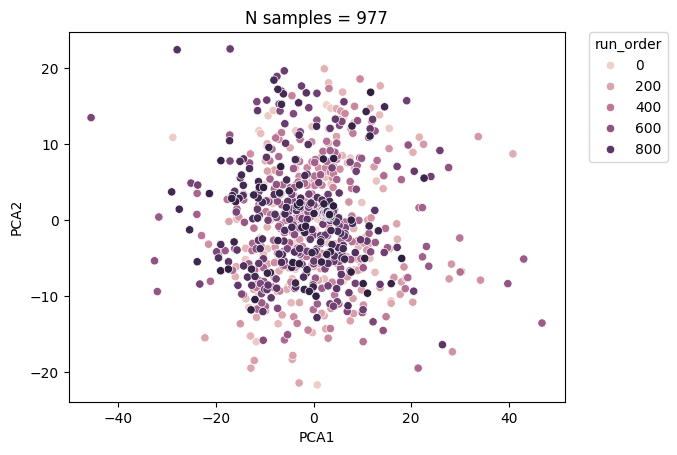

In [159]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,metadata,col_name='run_order',yes_umap=False)

### Save the prepared study to be used for pretraining

In [160]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## Shanghai Lung Cancer

In [161]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST002773_Shanghai_LungCancer'
metab_study_name = 'ST002773'

# the poolmap intensity matrix has already been matched to the pretrain features
# alignment_df = pd.read_csv(f'{data_dir}/alignment_df.csv', index_col=0)
# alignment_df.dropna(axis=0, how='all', inplace=True)

norm_intensity = pd.read_csv(f'{data_dir}/combined/final_peaks/intensity_max_pool.csv', index_col=0)

In [180]:
sample_info = pd.read_csv(f'{data_dir}/combined/sample_info/sample_info.csv', index_col=0)
metadata = pd.read_csv(f'{clean_metadata_dir}/metadata_{metab_study_name}.csv', index_col=0)
metadata['Ref']= 0
metadata.loc[metadata['Sample_Class']=='PooledQAQC','Ref'] = 1
metadata =metadata.join(sample_info[['run_order']],how='left')



# metadata = pd.read_csv(f'{data_dir}/metadata_complete.csv', index_col=0)
# metadata = metadata.loc[norm_intensity.columns].copy()
# metadata['Ref'] = metadata['Pool'].astype(int)
# metadata['batch_id'] = metadata['Batch'].astype(int)

In [170]:
cohort_align = pd.Series(norm_intensity.index, index=norm_intensity.index) #already aligned, so just use the index
intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1400
number of missing pretrained features: 1336


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


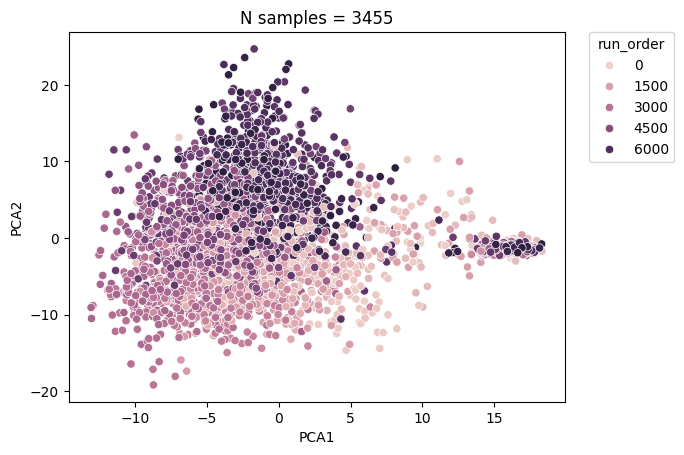

In [173]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,metadata,col_name='run_order',yes_umap=False)

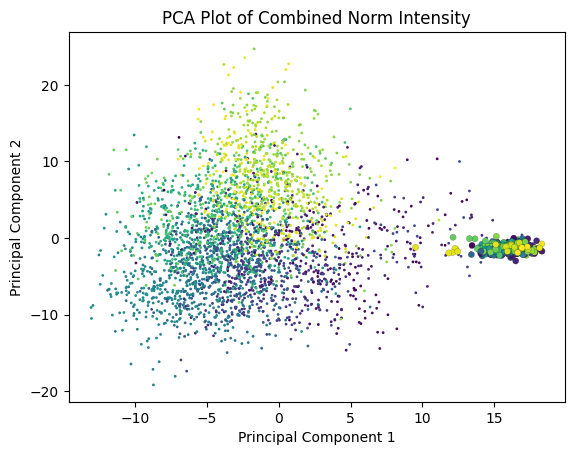

In [181]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=1, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=20, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [182]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## ST000601
Untargeted LC-MS metabolomics analysis of human COPD plasma
correspond to cohort id 547


In [183]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'
alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

In [184]:
metab_study_name = 'ST000601'
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST000601/job_id_547'
cohort_id = 547
cohort_align = alignment_df[f'{cohort_id}'].dropna()

In [185]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)
metadata_file = os.path.join(clean_metadata_dir, f'metadata_{metab_study_name}.csv')
metadata = pd.read_csv(metadata_file, index_col=0)
metadata = sample_info.join(metadata, how='left')


# cleaned_metadata_file = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/source_metadata/metadata_2025_july_05/metadata_ST000601.csv'
# sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)

# metadata = pd.read_csv(cleaned_metadata_file, index_col=0)
# metadata = sample_info.join(metadata)

metadata.loc[metadata['Sex'].isna(),'Ref'] = 1

In [186]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_map_norm.csv', index_col=0)

intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 470
number of missing pretrained features: 2266


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


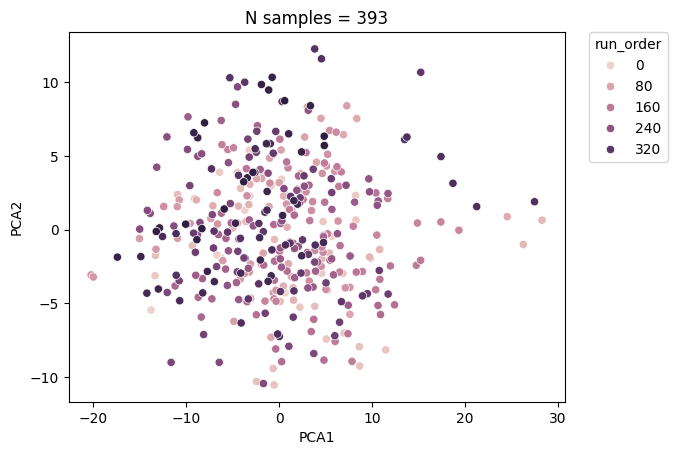

In [187]:
embedding0 = generate_pca_embedding(intensity_df.T).values

plot_pca(embedding0,metadata,col_name='run_order',yes_umap=False)

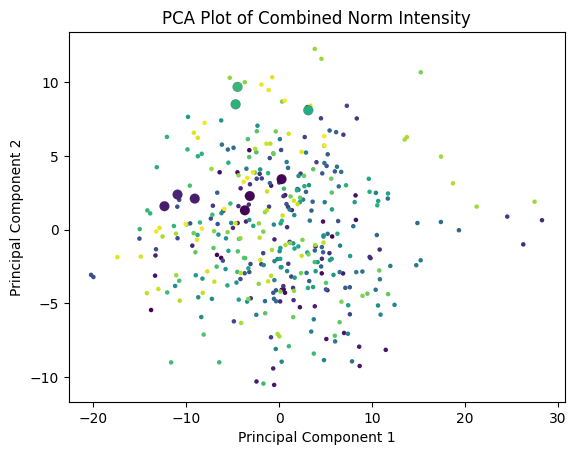

In [188]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=5, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=50, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [189]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## ST001422
Previously I think I was too quick to remove outliers from this dataset. 
between these two studies, there are another 94 samples that have Sex
with 48 of those having Age, BMI and cancer information. So we will add these samples back in.

ST001422 corresponds to job ids: 502, 618


When mzlearn was run, we did not know which files were reference. now that we do we could run pool map normalizaiton instead of using synthetic norm

In [190]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'
alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

In [191]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST001422/job_id_502'
cohort_id = 502
metab_study_name = 'ST001422'

cohort_align = alignment_df[f'{cohort_id}'].dropna()

In [192]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)
metadata_file = os.path.join(clean_metadata_dir, f'metadata_{metab_study_name}.csv')
metadata = pd.read_csv(metadata_file, index_col=0)
metadata = sample_info.join(metadata, how='left')
metadata.loc[metadata['Sample_Class']=='Study_QC_Sample','Ref'] = 1

In [193]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_map_norm.csv', index_col=0)

intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1606
number of missing pretrained features: 1130


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [194]:
embedding0 = generate_pca_embedding(intensity_df.T).values

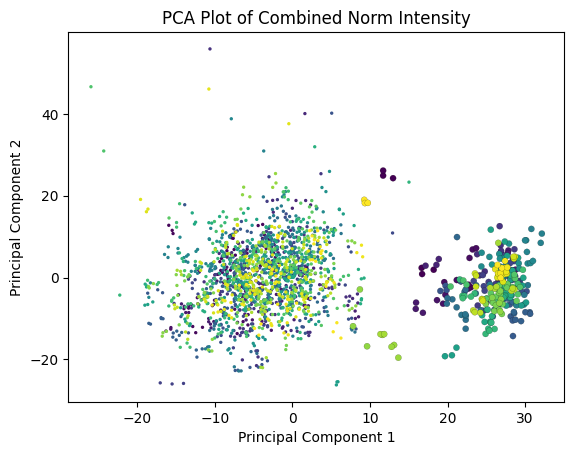

In [195]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())
marker_size = 2

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=marker_size, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=10*marker_size, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [196]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## ST001423

Previously I think I was too quick to remove outliers from this dataset. 
between these two studies, there are another 94 samples that have Sex
with 48 of those having Age, BMI and cancer information. So we will add these samples back in.

ST001423 corresponds to job ids: 526,  619

When mzlearn was run, we did not know which files were reference. now that we do we could run pool map normalizaiton instead of using synthetic norm

In [215]:
org_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1/'
alignment_df = pd.read_csv(f'{org_alignment_dir}/alignment_df.csv', index_col=0)

In [216]:
data_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/MS_Data/ST001423/job_id_526'
cohort_id = 526
metab_study_name = 'ST001423'
cohort_align = alignment_df[f'{cohort_id}'].dropna()


In [217]:
sample_info = pd.read_csv(f'{data_dir}/sample_info/sample_info.csv', index_col=0)
metadata_file = os.path.join(clean_metadata_dir, f'metadata_{metab_study_name}.csv')
metadata = pd.read_csv(metadata_file, index_col=0)
metadata = sample_info.join(metadata, how='left')
metadata.loc[metadata['Sample_Class']=='Study_QC_Sample','Ref'] = 1

In [218]:
norm_intensity = pd.read_csv(f'{data_dir}/final_peaks/intensity_max_synthetic_norm.csv', index_col=0)

intensity_df, nan_df = align_to_existing(norm_intensity.T, pretrain_feats, cohort_align, fill_na=True, std_scale=True, log2_scale=True,
                                            full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)

number of common pretrained features: 1601
number of missing pretrained features: 1135


/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [219]:
embedding0 = generate_pca_embedding(intensity_df.T).values

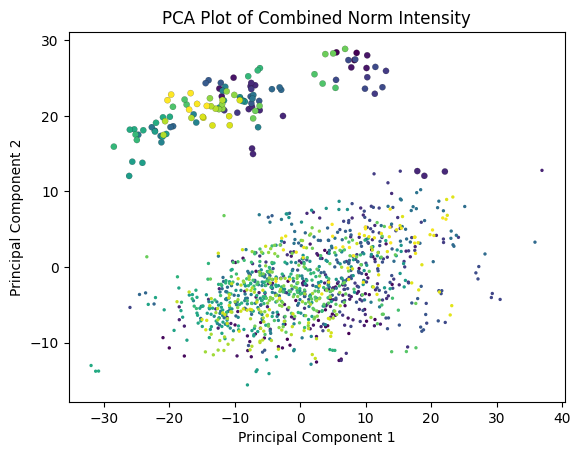

In [220]:
run_order = metadata.loc[intensity_df.index,'run_order'].values
ref_samples = metadata.loc[intensity_df.index,'Ref'].values
color_norm = plt.Normalize(vmin=0, vmax=metadata['run_order'].max())
marker_size = 2

# Create PCA plot
plt.scatter(embedding0[:, 0], embedding0[:, 1], c=run_order, cmap='viridis', s=marker_size, norm=color_norm)

plt.scatter(embedding0[:, 0][ref_samples.astype(bool)], 
            embedding0[:, 1][ref_samples.astype(bool)], 
            c=run_order[ref_samples.astype(bool)], cmap='viridis', 
            s=10*marker_size, norm=color_norm, edgecolors='black', linewidths=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot of Combined Norm Intensity')
plt.show()

In [221]:
# save the data 
save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
os.makedirs(save_dir, exist_ok=True)
intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
metadata.to_csv(f'{save_dir}/metadata.csv')

## Break apart the previous combined aligned dataset

In [222]:
previous_alignment_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_36/grid_search_index_1'

previous_intensity_file = f"{previous_alignment_dir}/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/X.csv"
previous_nans_file = f"{previous_alignment_dir}/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/nans.csv"
previous_metadata_file = f"{previous_alignment_dir}/subset_robust_Freq, Cohort Log Size Weighted_0.2_rem_['549', '551', '547']_recompute/y.csv"
previous_metadata = pd.read_csv(previous_metadata_file, index_col=0)

In [229]:
previous_metadata['Previous Study ID'] = previous_metadata['Study ID Expanded']
previous_metadata['Previous Job ID'] = previous_metadata['cohort_id']
previous_metadata['Matt Set Label'] = previous_metadata['Matt Set']
previous_metadata['Previous Set'] = previous_metadata['Set']
# 'run_order', 'MV'
previous_metadata['Previous run_order'] = previous_metadata['run_order']
previous_metadata['Previous MV'] = previous_metadata['MV']
keep_previous_cols = ['Previous Study ID', 'Previous Job ID', 'Matt Set Label', 'Previous Set', 'Previous run_order', 'Previous MV']

In [223]:
previous_intensity = pd.read_csv(previous_intensity_file, index_col=0)

In [224]:
previous_nans = pd.read_csv(previous_nans_file, index_col=0)

print('check if missing values in the previous intensity')
print(previous_intensity.isna().sum().sum())

check if missing values in the previous intensity
0


In [231]:
study_id_list = previous_metadata['Study ID Expanded'].unique()
skip_study_id = ['ST000601','ST001422','ST001423','ST002773','stanford-hmp2']
all_study_id_list = list(set(study_id_list).union(set(skip_study_id)))

In [226]:

for metab_study_name in study_id_list:
    if metab_study_name in skip_study_id:
        continue

    if os.path.exists(f'{SAVE_BASE_DIR}/{metab_study_name}/metadata.csv'):
        print(f'{metab_study_name} already exists')
        continue

    print(f'Processing {metab_study_name}')
        
    previous_metadata_subset = previous_metadata[previous_metadata['Study ID Expanded']==metab_study_name].copy()
    previous_intensity_subset = previous_intensity.loc[previous_metadata_subset.index,:].copy()
    previous_nans_subset = previous_nans.loc[previous_metadata_subset.index,:].copy()

    study_metadata = pd.read_csv(f'{clean_metadata_dir}/metadata_{metab_study_name}.csv', index_col=0)
    if 'mzml path' in study_metadata.columns:
        study_metadata.index = study_metadata['mzml path'].to_list()

    # intensity_df, nan_df = align_to_existing(previous_intensity_subset.T, pretrain_feats, previous_metadata_subset['Cohort ID'], fill_na=True, std_scale=True, log2_scale=True,
    #                                         full_missing_method='mean', partial_missing_method='mean', fill_partial_missing_first=True)   


    intensity_df = previous_intensity_subset
    nan_df = previous_nans_subset
    missing_samples1 = [x for x in intensity_df.index if x not in study_metadata.index]
    if len(missing_samples1)>0:
        print('number of samples in the intensity matrix, missing in cleaned metadata:' , len(missing_samples1))
        print('samples in the intensity matrix, missing in cleaned metadata:' , missing_samples1)



    missing_samples2 = [x for x in study_metadata.index if x not in intensity_df.index]
    if len(missing_samples2)>0:
        print('number of samples in the cleaned metadata, missing in intensity matrix:' , len(missing_samples2))
        print('samples in the cleaned metadata, missing in intensity matrix:' , missing_samples2)
    
    common_samples = list(set(intensity_df.index).intersection(study_metadata.index))
    metadata = study_metadata.loc[common_samples].copy()
    metadata = previous_metadata_subset[keep_previous_cols].join(metadata, how='outer')

    save_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
    os.makedirs(save_dir, exist_ok=True)
    intensity_df.to_csv(f'{save_dir}/scaled_intensity_matrix.csv')
    nan_df.to_csv(f'{save_dir}/nan_matrix.csv')
    metadata.to_csv(f'{save_dir}/metadata.csv')

Processing ST000909
Processing ST001918
samples in the cleaned metadata, missing in intensity matrix: ['VT_170728_M021_279.mzML', 'VT_170728_M021_281.mzML', 'VT_170728_M021_002.mzML', 'VT_170728_M021_008.mzML', 'VT_170728_M021_014.mzML', 'VT_170728_M021_020.mzML', 'VT_170728_M021_026.mzML', 'VT_170728_M021_032.mzML', 'VT_170728_M021_038.mzML', 'VT_170728_M021_044.mzML', 'VT_170728_M021_050.mzML', 'VT_170728_M021_056.mzML', 'VT_170728_M021_062.mzML', 'VT_170728_M021_068.mzML', 'VT_170728_M021_074.mzML', 'VT_170728_M021_080.mzML', 'VT_170728_M021_086.mzML', 'VT_170728_M021_092.mzML', 'VT_170728_M021_098.mzML', 'VT_170728_M021_104.mzML', 'VT_170728_M021_110.mzML', 'VT_170728_M021_116.mzML', 'VT_170728_M021_122.mzML', 'VT_170728_M021_128.mzML', 'VT_170728_M021_134.mzML', 'VT_170728_M021_140.mzML', 'VT_170728_M021_146.mzML', 'VT_170728_M021_152.mzML', 'VT_170728_M021_158.mzML', 'VT_170728_M021_164.mzML', 'VT_170728_M021_170.mzML', 'VT_170728_M021_176.mzML', 'VT_170728_M021_182.mzML', 'VT_17

## Compile all of the metadata

In [362]:
all_metadata_list = []
for metab_study_name in all_study_id_list:
    load_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
    if not os.path.exists(f'{load_dir}/metadata.csv'):
        print(f'{metab_study_name} is missing')
        continue
    metadata = pd.read_csv(f'{load_dir}/metadata.csv', index_col=0)

    all_metadata_list.append(metadata)

all_metadata = pd.concat(all_metadata_list)
all_metadata['is Female']  = all_metadata['Sex'].map({'F':1, 'M':0})
# all_metadata.to_csv(f'{SAVE_BASE_DIR}/metadata.csv')

In [363]:
all_metadata['Pretrain All'] = True
all_metadata['Finetune All'] = False
rcc3_baseline = all_metadata[(all_metadata['Study ID'] == 'ST001237') & (all_metadata['Timepoint']=='baseline')].index.to_list()
all_metadata.loc[rcc3_baseline,'Pretrain All'] = False
all_metadata.loc[rcc3_baseline,'Finetune All'] = True
                     

In [364]:
all_metadata['Sample_Class'].value_counts()

Sample_Class
Study_Sample       3272
Study_sample       2514
Study_QAQC          486
Study_QC_Sample     473
PooledQAQC          449
Pooled_Plasma        34
NIST1950              6
NIST_1950             6
Name: count, dtype: int64

In [365]:
qc_samples = all_metadata[(all_metadata['Sample_Class']=='NIST1950') | 
                            (all_metadata['Sample_Class']=='NIST_1950') |
                            (all_metadata['Sample_Class']=='Study_QC_Sample') |
                            (all_metadata['Sample_Class']=='Study_QAQC')].index.to_list()

all_metadata.loc[qc_samples,'Pretrain All'] = False
all_metadata.loc[qc_samples,'Finetune All'] = False       

In [366]:
if 'Matt Set Label' not in all_metadata.columns:
    common_with_prev = [x for x in all_metadata.index if x in previous_metadata.index]
    all_metadata['Matt Set Label'] = 'NA'
    all_metadata.loc[common_with_prev,'Matt Set Label'] = previous_metadata.loc[common_with_prev,'Matt Set Label']

In [367]:
from sklearn.model_selection import train_test_split, StratifiedGroupKFold


def smart_trainval_split(metadata, suffix='Pretrain All',stratify_cols=['Study ID','Sex'],test_frac=0.1):
    metadata.dropna(axis=1, how='all', inplace=True)
    y = metadata[metadata[f'{suffix}']].copy()
    y = y[stratify_cols+['Subject ID']].copy()

    if 'Subject ID' in y.columns:
        y_with_sample_id = y[~y['Subject ID'].isna()].copy()
        y_with_sample_id['Subject ID'] = y_with_sample_id['Subject ID'].astype(str)
        y_without_sample_id = y[y['Subject ID'].isna()].copy()
    else:
        y_with_sample_id = pd.DataFrame(index=y.index)
        y_without_sample_id = y

    # fill missing value of numeric columns with -1
    numeric_cols = y_without_sample_id.select_dtypes(include=[np.number]).columns
    y_without_sample_id[numeric_cols] = y_without_sample_id[numeric_cols].fillna(-1)
    y_with_sample_id[numeric_cols] = y_with_sample_id[numeric_cols].fillna(-1)

    # fill missing value of non-numeric columns with 'missing'
    non_numeric_cols = y_without_sample_id.select_dtypes(exclude=[np.number]).columns
    y_without_sample_id[non_numeric_cols] = y_without_sample_id[non_numeric_cols].fillna('missing')
    y_with_sample_id[non_numeric_cols] = y_with_sample_id[non_numeric_cols].fillna('missing')

    n_splits = round(1/test_frac)

    if len(y_with_sample_id) > 0:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, random_state=42, shuffle=True)
        # print(y)
        if len(stratify_cols) > 1:
            train_inds, val_inds = next(sgkf.split(y_with_sample_id, y_with_sample_id[stratify_cols[0]], groups=y_with_sample_id['Subject ID']))
        else:
            train_inds, val_inds = next(sgkf.split(y_with_sample_id, y_with_sample_id[stratify_cols], groups=y_with_sample_id['Subject ID']))

        train_ids1 = y_with_sample_id.index[train_inds].to_list()
        val_ids1 = y_with_sample_id.index[val_inds].to_list()
    else:
        train_ids1 = []
        val_ids1 = []


    if len(y_without_sample_id) > 0:
        train_ids2, val_ids2 = train_test_split(y_without_sample_id.index, test_size=test_frac, stratify=y_without_sample_id[stratify_cols], random_state=42)
        train_ids2 = train_ids2.tolist()
        val_ids2 = val_ids2.tolist()
    else:
        train_ids2 = []
        val_ids2 = []

    train_ids = train_ids1 + train_ids2
    val_ids = val_ids1 + val_ids2

    return train_ids, val_ids


def assign_sets(metadata):
    train_ids, val_ids = smart_trainval_split(metadata, suffix='Pretrain All')
    metadata['Pretrain Discovery'] = False
    metadata['Pretrain Test'] = False
    metadata.loc[train_ids,'Pretrain Discovery'] = True
    metadata.loc[val_ids,'Pretrain Test'] = True

    train_ids, val_ids = smart_trainval_split(metadata, suffix='Pretrain Discovery')
    metadata['Pretrain Discovery Train'] = False
    metadata['Pretrain Discovery Val'] = False
    metadata.loc[train_ids,'Pretrain Discovery Train'] = True
    metadata.loc[val_ids,'Pretrain Discovery Val'] = True

    if 'Matt Set Label' not in metadata.columns:
        train_ids, val_ids = smart_trainval_split(metadata, suffix='Finetune All', stratify_cols=['IMDC','MSKCC'])
        metadata['Finetune Discovery'] = False
        metadata['Finetune Test'] = False
        metadata.loc[train_ids,'Finetune Discovery'] = True
        metadata.loc[val_ids,'Finetune Test'] = True

        train_ids, val_ids = smart_trainval_split(metadata, suffix='Finetune Discovery', stratify_cols=['IMDC','MSKCC'])
        metadata['Finetune Discovery Train'] = False
        metadata['Finetune Discovery Val'] = False
        metadata.loc[train_ids,'Finetune Discovery Train'] = True
        metadata.loc[val_ids,'Finetune Discovery Val'] = True
    
    else:
        print('found Matt Set labels for RCC3 fintune')
        train_ids = metadata[(metadata['Matt Set Label']=='Train') & (metadata['Finetune All'])].index.to_list()
        val_ids = metadata[(metadata['Matt Set Label']=='Val') & (metadata['Finetune All'])].index.to_list()
        disc_ids = train_ids + val_ids
        test_ids = metadata[(metadata['Matt Set Label']=='Test') & (metadata['Finetune All'])].index.to_list()
        metadata['Finetune Discovery'] = False
        metadata['Finetune Test'] = False
        metadata.loc[disc_ids,'Finetune Discovery'] = True
        metadata.loc[test_ids,'Finetune Test'] = True

        metadata['Finetune Discovery Train'] = False
        metadata['Finetune Discovery Val'] = False
        metadata.loc[train_ids,'Finetune Discovery Train'] = True
        metadata.loc[val_ids,'Finetune Discovery Val'] = True

        

    metadata['Set'] = 'skip'
    metadata.loc[metadata['Pretrain Discovery Train'],'Set'] = 'Pretrain Discovery Train'
    metadata.loc[metadata['Pretrain Discovery Val'],'Set'] = 'Pretrain Discovery Val'
    metadata.loc[metadata['Pretrain Test'],'Set'] = 'Pretrain Test'
    metadata.loc[metadata['Finetune Discovery Train'],'Set'] = 'Finetune Discovery Train'
    metadata.loc[metadata['Finetune Discovery Val'],'Set'] = 'Finetune Discovery Val'
    metadata.loc[metadata['Finetune Test'],'Set'] = 'Finetune Test'


    if not (metadata['Set'].value_counts().sum() == metadata.shape[0]):
        print('Error in assigning the sets, some samples assigned to more than one set')
        
    return metadata



In [368]:
all_metadata = assign_sets(all_metadata)

found Matt Set labels for RCC3 fintune


In [369]:
all_metadata['Set'].value_counts()

Set
Pretrain Discovery Train    16847
Pretrain Test                2058
Pretrain Discovery Val       1903
skip                          971
Finetune Discovery Train      450
Finetune Test                 147
Finetune Discovery Val        144
Name: count, dtype: int64

In [370]:
all_metadata['Pretrain All'].value_counts()

Pretrain All
True     20808
False     1712
Name: count, dtype: int64

In [371]:
nan_subject_ids = all_metadata[all_metadata['Subject ID'].isna()].index.to_list()
num_nan_subject_ids = len(nan_subject_ids)
num_unique_real_subject_ids = all_metadata['Subject ID'].nunique()
num_pool_samples = all_metadata['Sample_Class'].str.contains('Pool').sum()
num_skip_samples = (all_metadata['Set'] == 'skip').sum()

# note: not all the pool samples are identified by 'Sample_Class" 
tot_num_subject_ids = num_nan_subject_ids + num_unique_real_subject_ids - num_pool_samples - num_skip_samples

print(f'Number of samples with missing Subject ID: {num_nan_subject_ids}')
print(f'Number of unique real Subject IDs: {num_unique_real_subject_ids}')
print(f'Number of pool samples: {num_pool_samples}')
print(f'Total number of unqiue: {tot_num_subject_ids}')

Number of samples with missing Subject ID: 12165
Number of unique real Subject IDs: 3400
Number of pool samples: 483
Total number of unqiue: 14111


In [372]:
# if any BMI value is not numeric, replace it with nan
all_metadata['BMI'] = pd.to_numeric(all_metadata['BMI'], errors='coerce')
all_metadata['Age'] = pd.to_numeric(all_metadata['Age'], errors='coerce')
all_metadata['Smoking Status'] = all_metadata['Smoking Status'].map({'Former': 'Current or Former', 'Current': 'Current or Former',
                                                                    'Never': 'Never', 'Current or Former': 'Current or Former'}, na_action='ignore')


In [373]:
all_metadata['Smoking Status'].value_counts()

Smoking Status
Never                3416
Current or Former     663
Name: count, dtype: int64

In [374]:
all_metadata.to_csv(f'{SAVE_BASE_DIR}/metadata.csv')

In [375]:
print('Number of samples')
print(all_metadata.shape[0])

print('Sex counts:')
print(all_metadata.shape[0] - all_metadata['Sex'].isna().sum())

print('BMI counts:')
print(all_metadata.shape[0] - all_metadata['BMI'].isna().sum())

print('Age counts:')
print(all_metadata.shape[0] - all_metadata['Age'].isna().sum())

print('Smoking Status counts:')
print(all_metadata.shape[0] - all_metadata['Smoking Status'].isna().sum())

print('Study Ids')
print(all_metadata['Study ID'].nunique())

Number of samples
22520
Sex counts:
11355
BMI counts:
3938
Age counts:
8679
Smoking Status counts:
4079
Study Ids
22


<Axes: xlabel='Cancer Risk', ylabel='Count'>

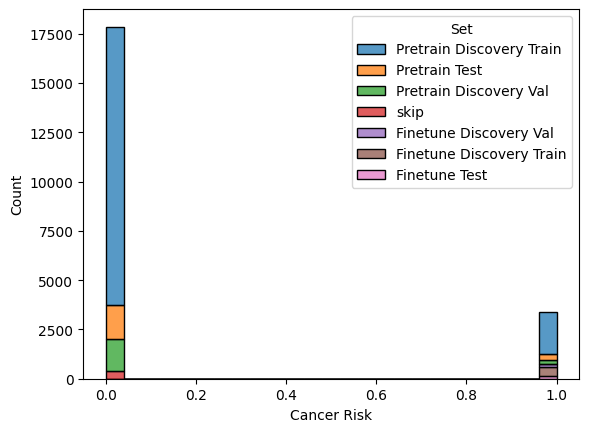

In [376]:
sns.histplot(data=all_metadata,x='Cancer Risk', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Smoking Status', ylabel='Count'>

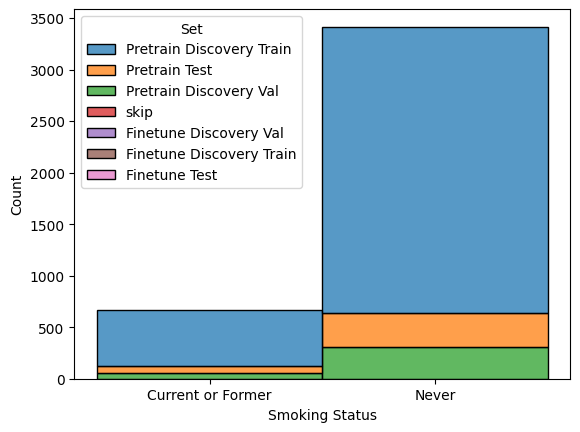

In [377]:
sns.histplot(data=all_metadata,x='Smoking Status', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Sex', ylabel='Count'>

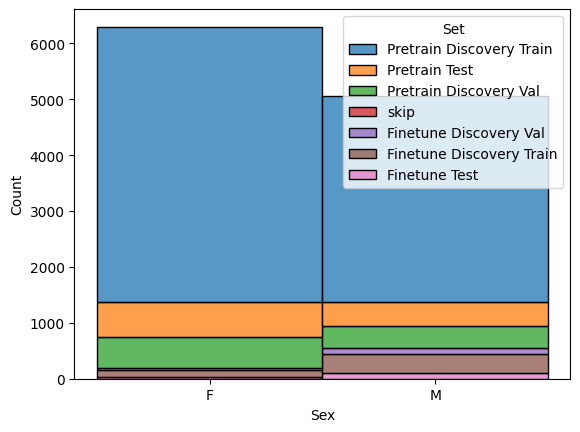

In [378]:
sns.histplot(data=all_metadata,x='Sex', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Age', ylabel='Count'>

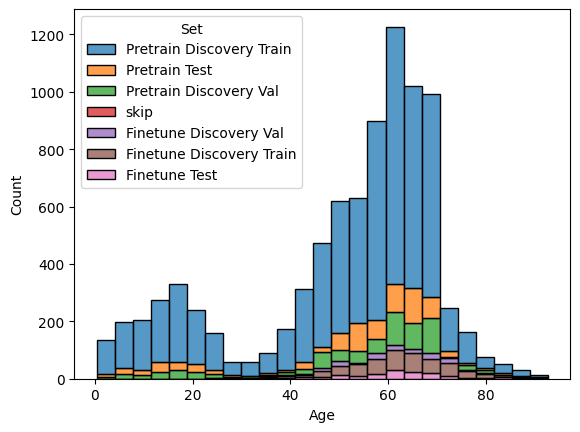

In [379]:
sns.histplot(data=all_metadata,x='Age', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='BMI', ylabel='Count'>

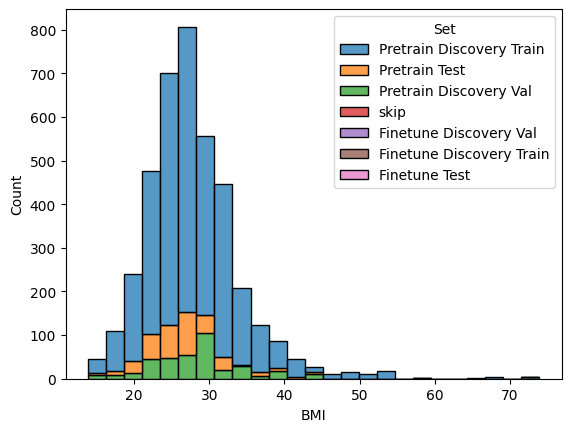

In [380]:
sns.histplot(data=all_metadata,x='BMI', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Count', ylabel='Study ID'>

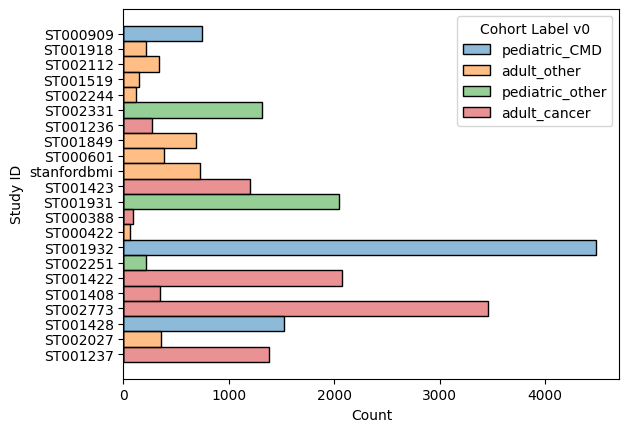

In [381]:
sns.histplot(y='Study ID', hue='Cohort Label v0', data=all_metadata)

## Save the X, y data for pretraining

In [424]:
def get_format_for_model(input_data_dir,output_dir,sample_selection_col,metadata_cols=[],save_nan=False):

    all_metadata = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)
    # all_metadata = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0, low_memory=False)
    study_id_list = all_metadata['Study ID'].unique()

    select_ids = all_metadata[all_metadata[sample_selection_col]].index.to_list()
    
    print(f'Number of samples selected: {len(select_ids)}')
    if len(metadata_cols)> 0:
        y = all_metadata.loc[select_ids,metadata_cols].copy()
    else:
        y = all_metadata.loc[select_ids,:].copy()

    save_file_id = sample_selection_col.replace(' ','_')
    y_file = f'{output_dir}/y_{save_file_id}.csv'
    if save_nan:
        X_file = f'{output_dir}/nan_{save_file_id}.csv'
    else:
        X_file = f'{output_dir}/X_{save_file_id}.csv'

    
    X_list = []

    for study_id in study_id_list:
        # print(study_id)
        if save_nan:
            intensity_file = f'{input_data_dir}/{study_id}/nan_matrix.csv'
        else:
            intensity_file = f'{input_data_dir}/{study_id}/scaled_intensity_matrix.csv'

        if os.path.exists(intensity_file):
            study_ids = all_metadata[all_metadata['Study ID']==study_id].index.to_list()
            subset_select_ids = list(set(select_ids).intersection(study_ids))
            intensity_df = pd.read_csv(intensity_file, index_col=0)
            intensity_df = intensity_df.loc[subset_select_ids].copy()
            X_list.append(intensity_df)
        else:
            print(f'{study_id} is missing')
            continue

    X = pd.concat(X_list, axis=1)

    if len(y) != X.shape[0]:
        print('Warning, the number of samples in the metadata and intensity matrix do not match')
        common_samples = list(set(X.index).intersection(y.index))
        X = X.loc[common_samples].copy()
        y = y.loc[common_samples].copy()
    else:
        y = y.loc[X.index].copy()


    y.to_csv(y_file)
    X.to_csv(X_file)

    return

        


In [403]:
all_metadata = pd.read_csv(f'{SAVE_BASE_DIR}/metadata.csv', index_col=0, low_memory=False)

/var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_41729/908196949.py:1: DtypeWarning: Columns (2,11,13,17,18,19,31,32,38,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  all_metadata = pd.read_csv(f'{SAVE_BASE_DIR}/metadata.csv', index_col=0)


In [425]:
OUTPUT_DIR = os.path.join(SAVE_BASE_DIR,'formatted_data')
os.makedirs(OUTPUT_DIR, exist_ok=True)
get_format_for_model(SAVE_BASE_DIR,OUTPUT_DIR,'Finetune Discovery Train')

/var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_41729/4253344040.py:3: DtypeWarning: Columns (2,11,13,17,18,19,31,32,38,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  all_metadata = pd.read_csv(f'{input_data_dir}/metadata.csv', index_col=0)


Number of samples selected: 450
nan is missing
stanfordbmi is missing


In [420]:
select_ids

['0710_Marios_PD1_Inhib2_HP-E9314438-7.mzML',
 '0444_Marios_PD1_Inhib2_HP-AE383168-7.mzML',
 '0328_Marios_PD1_Inhib2_HP-AE330678-6.mzML',
 '0920_Marios_PD1_Inhib2_HP-AF003923-9.mzML',
 '0012_Marios_PD1_Inhib2_HP-AE487819-7.mzML',
 '1091_Marios_PD1_Inhib2_HP-AF016229-9.mzML',
 '1160_Marios_PD1_Inhib2_HP-E9479160-7.mzML',
 '0738_Marios_PD1_Inhib2_HP-E9096030-7.mzML',
 '0782_Marios_PD1_Inhib2_HP-L1366488-10.mzML',
 '0340_Marios_PD1_Inhib2_HP-AE294679-7.mzML',
 '1056_Marios_PD1_Inhib2_HP-E9474282-7.mzML',
 '0327_Marios_PD1_Inhib2_HP-S3781279-7.mzML',
 '0149_Marios_PD1_Inhib2_HP-S3472022-7.mzML',
 '1095_Marios_PD1_Inhib2_HP-S3681809-7.mzML',
 '0369_Marios_PD1_Inhib2_HP-AD452581-6.mzML',
 '0316_Marios_PD1_Inhib2_HP-AD610057-7.mzML',
 '0430_Marios_PD1_Inhib2_HP-E9103839-7.mzML',
 '1054_Marios_PD1_Inhib2_HP-S3704162-7.mzML',
 '0561_Marios_PD1_Inhib2_HP-EA341119-7.mzML',
 '0412_Marios_PD1_Inhib2_HP-E9712824-7.mzML',
 '1067_Marios_PD1_Inhib2_HP-E9314436-7.mzML',
 '0724_Marios_PD1_Inhib2_HP-AD490

In [382]:
all_metadata['Sex'].astype('category').cat.categories

Index(['F', 'M'], dtype='object')

In [397]:
temp = all_metadata.copy()
# shuffle the data
temp = temp.sample(frac=1).reset_index(drop=True)
temp['Sex'].astype('category').cat.categories

Index(['F', 'M'], dtype='object')

In [398]:
temp['Study ID'].astype('category').cat.categories

Index(['ST000388', 'ST000422', 'ST000601', 'ST000909', 'ST001236', 'ST001237',
       'ST001408', 'ST001422', 'ST001423', 'ST001428', 'ST001519', 'ST001849',
       'ST001918', 'ST001931', 'ST001932', 'ST002027', 'ST002112', 'ST002244',
       'ST002251', 'ST002331', 'ST002773', 'stanfordbmi'],
      dtype='object')

In [385]:
all_metadata['Sex']

VT_171031_M314_239.mzML                        NaN
VT_171029_M314_119.mzML                        NaN
VT_171028_M314_109.mzML                        NaN
VT_171031_M314_153.mzML                        NaN
VT_171028_M314_217.mzML                        NaN
                                              ... 
0860b_Marios_PD1_Inhib2_HP-PREFB45.mzML        NaN
0000u_Marios_PD1_Inhib2_HP-001400087-3.mzML    NaN
0340b_Marios_PD1_Inhib2_HP-PREFB18.mzML        NaN
0751_Marios_PD1_Inhib2_HP-EA088437-7.mzML        M
0052_Marios_PD1_Inhib2_HP-AF581651-8.mzML        F
Name: Sex, Length: 22520, dtype: object

In [384]:
all_metadata['Sex'].astype('category').cat.codes.values

array([-1, -1, -1, ..., -1,  1,  0], dtype=int8)

In [383]:
all_metadata['Sex'].astype('category').cat.codes

VT_171031_M314_239.mzML                       -1
VT_171029_M314_119.mzML                       -1
VT_171028_M314_109.mzML                       -1
VT_171031_M314_153.mzML                       -1
VT_171028_M314_217.mzML                       -1
                                              ..
0860b_Marios_PD1_Inhib2_HP-PREFB45.mzML       -1
0000u_Marios_PD1_Inhib2_HP-001400087-3.mzML   -1
0340b_Marios_PD1_Inhib2_HP-PREFB18.mzML       -1
0751_Marios_PD1_Inhib2_HP-EA088437-7.mzML      1
0052_Marios_PD1_Inhib2_HP-AF581651-8.mzML      0
Length: 22520, dtype: int8

In [ ]:
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
